<a href="https://colab.research.google.com/github/rennydoig/ssc22-case-comp/blob/main/Daisy_dir/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import csv
!pip install geopandas rtree
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022 SSC Case Study')
print(os.getcwd())

     |████████████████████████████████| 1.0 MB 13.7 MB/s 
     |████████████████████████████████| 994 kB 61.7 MB/s 
     |████████████████████████████████| 6.3 MB 61.6 MB/s 
     |████████████████████████████████| 16.7 MB 46.7 MB/s 
Mounted at /content/drive
/content/drive/My Drive/2022 SSC Case Study


In [2]:
# Read data
df = pd.read_csv("ookla-canada-speed-tiles.csv")

# Check data shape
# print("data shape:{shape}".format(shape=df.shape),"\n", "data columns:{columns}".format(columns=list(df.columns))) 

Make an appropriate data set for BACKTESTING:


*   Aggregate tiles (quarkey) by census division (CDNAME).
*   Make each census division as a row and make columns as avg download/upload/latency in mbps over 2019-Q1 to 2021-Q4.
*   Additional columns are tests, DA_POP and geometry (MULTIPOLYGON).
*   Geometry: POLYGONs of tiles within the same census division are merged together into a MULTIPOLYGON for each census division.
*   Cluster labels are created based on geometry information using DBSCAN. 







In [3]:
def makeData(df, aggregate_by, conType, value):
    """ Make an appropriate data frame for prediction """
    '''
    df: orginal data in pd.DataFrame
    aggregate_by: 'quadkey' or 'DAUID' or 'CDNAME' or "PRNAME"
    conType: boolen, has the option to seperate connect type (e.g. fixed or mobile)
    value: 'avg_d_mbps' or 'avg_u_mbps' or 'avg_lat_ms'
    '''

    # Change kbps to mbps
    df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
    df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

    # Combine "year" and "quarter" and create a new column called "Date"
    df['Date'] = ["-".join(i) for i in zip(df['year'].astype(str), df['quarter'])]

    # Filter only rural areas: rows with NaN for either PCUID, PCNAME, PCTYPE, or PCCLASS
    cond = (df['PCUID'].isna()) | (df['PCNAME'].isna()) | (df['PCTYPE'].isna()) | (df['PCCLASS'].isna())
    df_rural = df[cond]
  
    # Aggregate data
    dat = dataAggregation(df_rural,aggregate_by,conType)

    # Transform the data: rows -> aggregate_by and columns -> Date/conn_type (if conn_type is True)
    if conType:
      output_data = dat.pivot_table(values=value,index=[aggregate_by],columns=['conn_type','Date'],aggfunc='mean')
    else:
      output_data = dat.pivot_table(values=value,index=[aggregate_by],columns=['Date'],aggfunc='mean')
    
    # Append 'tests' and 'DA_POP'
    output_data[['tests','DA_POP']] = dat.groupby(aggregate_by).agg({'tests':'sum','DA_POP':'sum'})


    # Append merged geometry
    index_name = output_data.index 
    df_geo = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    geo = []
    for x in index_name:
      A = df_geo[df_geo['CDNAME'] == x]
      geo.append(unary_union(A['geometry']))
    output_data['geometry'] = geo

    # Convert the data to GeoDataFrame
    output_data = gpd.GeoDataFrame(output_data, geometry='geometry', crs="EPSG:4326")
    return output_data


def dataAggregation(df, aggregate_by, conType):
    """ Aggregate data by tile, dissemination area, census division or province """
    '''
    df: orginal data in pd.DataFrame
    aggregate_by: 'quadkey' or 'DAUID' or 'CDNAME' or "PRNAME"
    conType: boolen, has the option to seperate connect type (e.g. fixed or mobile)
    '''

    # Weighted average of 'avg_d_mbps', 'avg_u_mbps' and 'avg_lat_ms', weight = 'tests'
    wm = lambda x: np.average(x, weights=df.loc[x.index, 'tests'])

    if conType:
      dat = df.groupby([aggregate_by,'Date','conn_type'],as_index=False).agg({"avg_u_mbps":wm,
                                                                              "avg_d_mbps":wm,
                                                                              "avg_lat_ms":wm,
                                                                              "tests":"sum",
                                                                              "DA_POP":"sum"})
    else: 
      dat = df.groupby([aggregate_by,'Date'],as_index=False).agg({"avg_u_mbps":wm,
                                                                  "avg_d_mbps":wm,
                                                                  "avg_lat_ms":wm,
                                                                  "tests":"sum",
                                                                  "DA_POP":"sum"})

    return dat

In [ ]:
# Final output data will look like
dat = makeData(df, 'CDUID', False, 'avg_d_mbps') # CDNAME: 238; CDUID: 22X
print(dat)

# Get the geometry information
dat['x'] = dat['geometry'].centroid.x
dat['y'] = dat['geometry'].centroid.y
coords = dat[['x','y']].to_numpy()

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


geopandas.geodataframe.GeoDataFrame

56


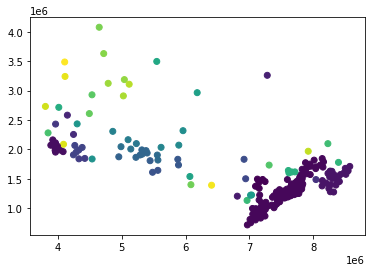

In [ ]:
eps = 100000
minPoint = 1
dbscan = DBSCAN(eps=eps, min_samples=minPoint) # groups ‘densely grouped’ data points into a single cluster
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_) + 1
labels.index = range(1, len(labels) + 1)
dat['GroupID'] = list(labels)
plt.scatter(dat['x'], dat['y'], c = labels)
print(len(set(labels)))

13


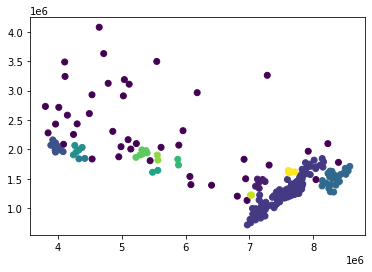

In [ ]:
eps = 100000
minPoint = 2
dbscan = DBSCAN(eps=eps, min_samples=minPoint)
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_) + 1
labels.index = range(1, len(labels) + 1)
dat['GroupID'] = list(labels)
plt.scatter(dat['x'], dat['y'], c = labels)
print(len(set(labels)))

125


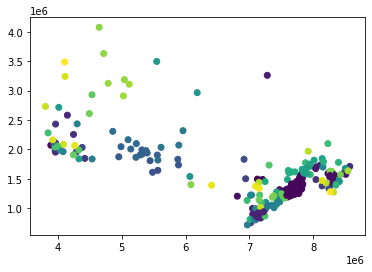

In [ ]:
eps = 50000
minPoint = 1
dbscan = DBSCAN(eps=eps, min_samples=minPoint)
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_) + 1
labels.index = range(1, len(labels) + 1)
dat['GroupID'] = list(labels)
plt.scatter(dat['x'], dat['y'], c = labels)
print(len(set(labels)))